# Caso Práctico: ¿Por qué se requiere una función de activación?

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## 1. Lectura del conjunto de datos

In [4]:
df = pd.read_csv("creditcard.csv")

## 2. Visualización del conjunto de datos

In [5]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


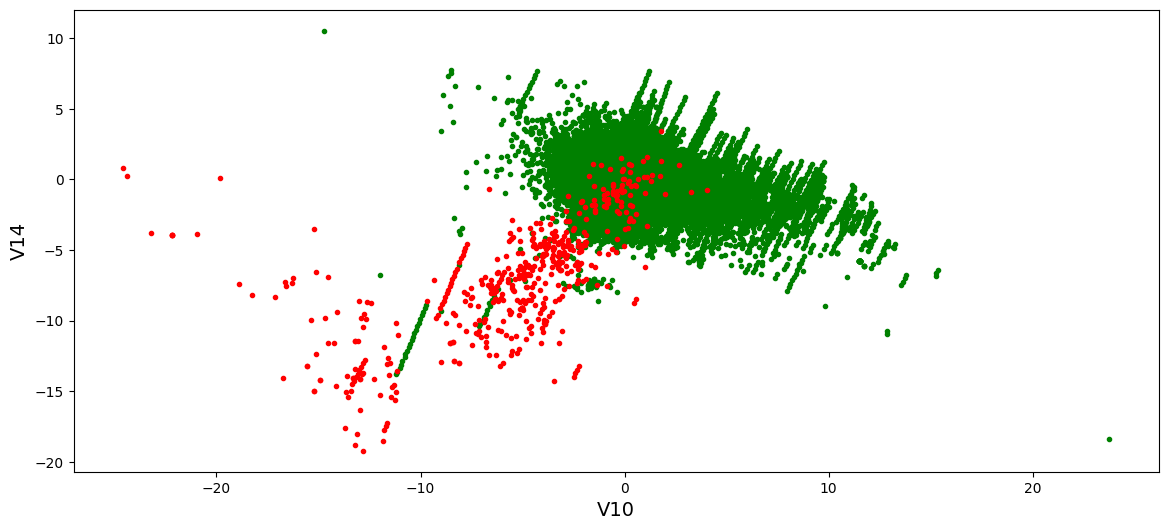

In [6]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

## 3. División del conjunto de datos

In [7]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [8]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

## 4. Funciones de activación

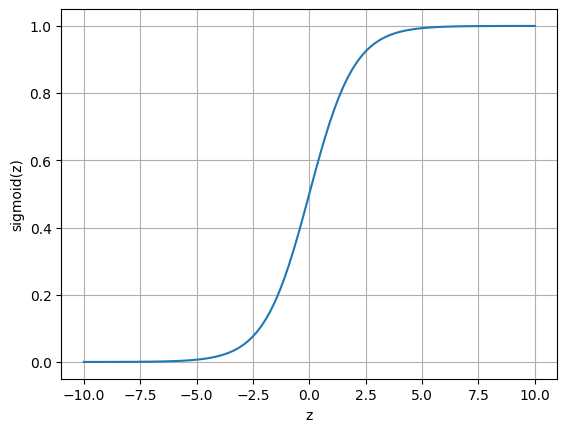

In [9]:
# Representación gráfica de la función sigmoide
from tensorflow.keras.backend import sigmoid

z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z))
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.grid()
plt.show()

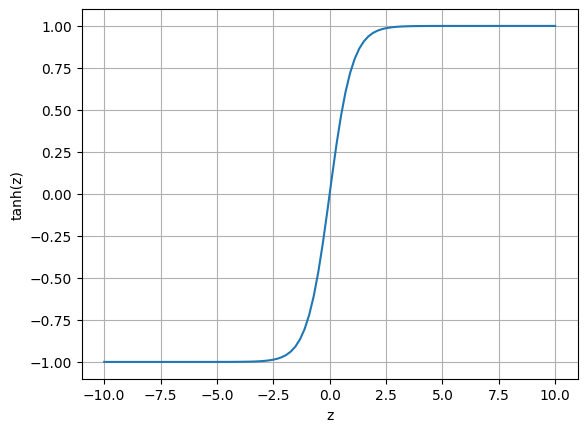

In [10]:
# Representación gráfica de la función tanh
from tensorflow.keras.backend import tanh

z = np.linspace(-10, 10, 100)
plt.plot(z, tanh(z))
plt.xlabel("z")
plt.ylabel("tanh(z)")
plt.grid()
plt.show()

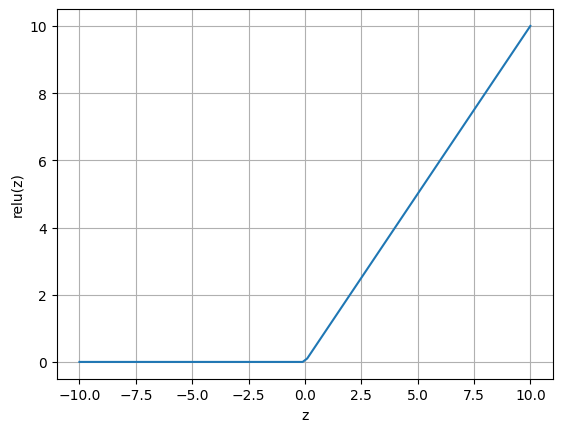

In [11]:
# Representación gráfica de la función relu
from tensorflow.keras.backend import relu

z = np.linspace(-10, 10, 100)
plt.plot(z, relu(z))
plt.xlabel("z")
plt.ylabel("relu(z)")
plt.grid()
plt.show()

## 5. Redes Neuronales Artificiales con un conjunto de datos de dos dimensiones

In [12]:
# Reducimos el conjunto de datos y nos quedamos con las características de entrada V10 y V14
X_train_reduced = X_train[["V10", "V14"]].copy()
X_val_reduced = X_val[["V10", "V14"]].copy()
X_test_reduced = X_test[["V10", "V14"]].copy()

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [14]:
# Definición de la arquitectura de la red neuronal
from tensorflow.keras import models
from tensorflow.keras import layers

activation = None

model = models.Sequential()
model.add(layers.Dense(128, activation=activation, input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(64, activation=activation))
model.add(layers.Dense(32, activation=activation))
model.add(layers.Dense(16, activation=activation))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy', 'Precision'])

In [16]:
# Resumen de las capas del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Entrenamos el modelo y calculamos el tiempo de ejecución
import time
start_time = time.time()

history = model.fit(X_train_reduced,
                   y_train,
                   epochs=30,
                   validation_data=(X_val_reduced, y_val))

print("\n--- Tiempo de ejecución: {} segundos ---".format(time.time() - start_time))

Epoch 1/30
5341/5341 [==============================] - 8s 1ms/step - loss: 0.0099 - accuracy: 0.9984 - precision: 0.5672 - val_loss: 0.0045 - val_accuracy: 0.9990 - val_precision: 0.8182
Epoch 2/30
5341/5341 [==============================] - 7s 1ms/step - loss: 0.0051 - accuracy: 0.9990 - precision: 0.8098 - val_loss: 0.0047 - val_accuracy: 0.9989 - val_precision: 0.8654
Epoch 3/30
5341/5341 [==============================] - 6s 1ms/step - loss: 0.0049 - accuracy: 0.9990 - precision: 0.8107 - val_loss: 0.0044 - val_accuracy: 0.9991 - val_precision: 0.8310
Epoch 4/30
5341/5341 [==============================] - 6s 1ms/step - loss: 0.0050 - accuracy: 0.9990 - precision: 0.8109 - val_loss: 0.0044 - val_accuracy: 0.9991 - val_precision: 0.8194
Epoch 5/30
5341/5341 [==============================] - 7s 1ms/step - loss: 0.0050 - accuracy: 0.9990 - precision: 0.8301 - val_loss: 0.0044 - val_accuracy: 0.9990 - val_precision: 0.8525
Epoch 6/30
5341/5341 [==============================] - 7s 1

**Representación del límite de decisión**

In [18]:
def plot_ann_decision_boundary(X, y, model, steps=1000):
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = labels.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)
    plt.xlabel("V10", fontsize=14)
    plt.ylabel("V14", fontsize=14)

31250/31250 [==============================] - 21s 678us/step


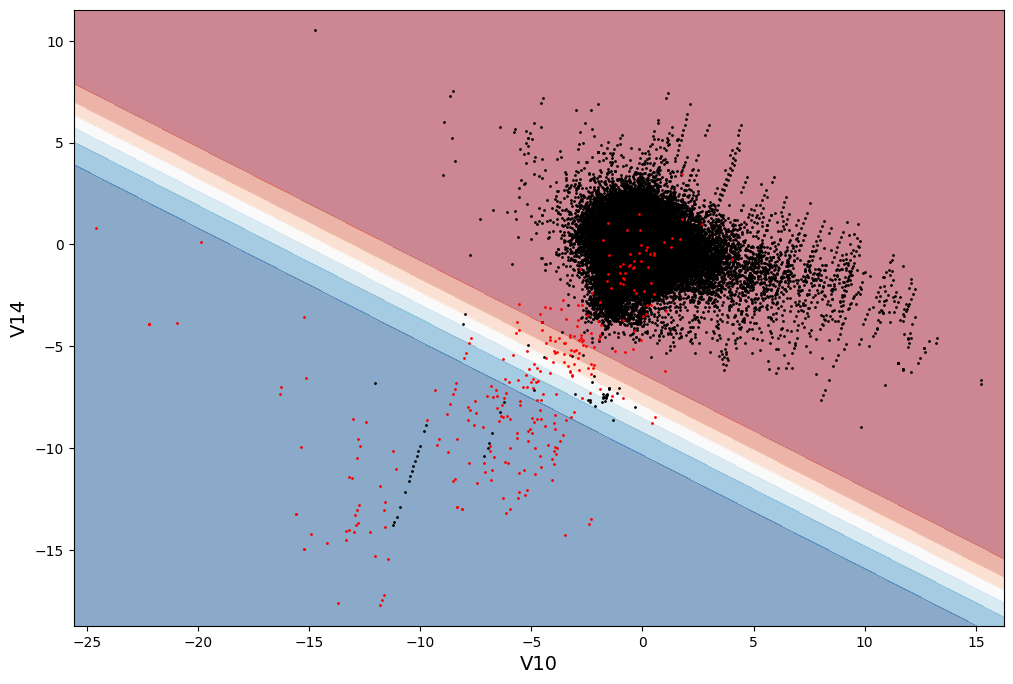

In [19]:
plt.figure(figsize=(12, 8))
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

**Representación de los ejemplos catalogados como maliciosos**

In [20]:
# Predicción con el conjunto de datos de entrenamiento
y_pred = model.predict(X_train_reduced).round(0)

5341/5341 [==============================] - 4s 750us/step


31250/31250 [==============================] - 24s 768us/step


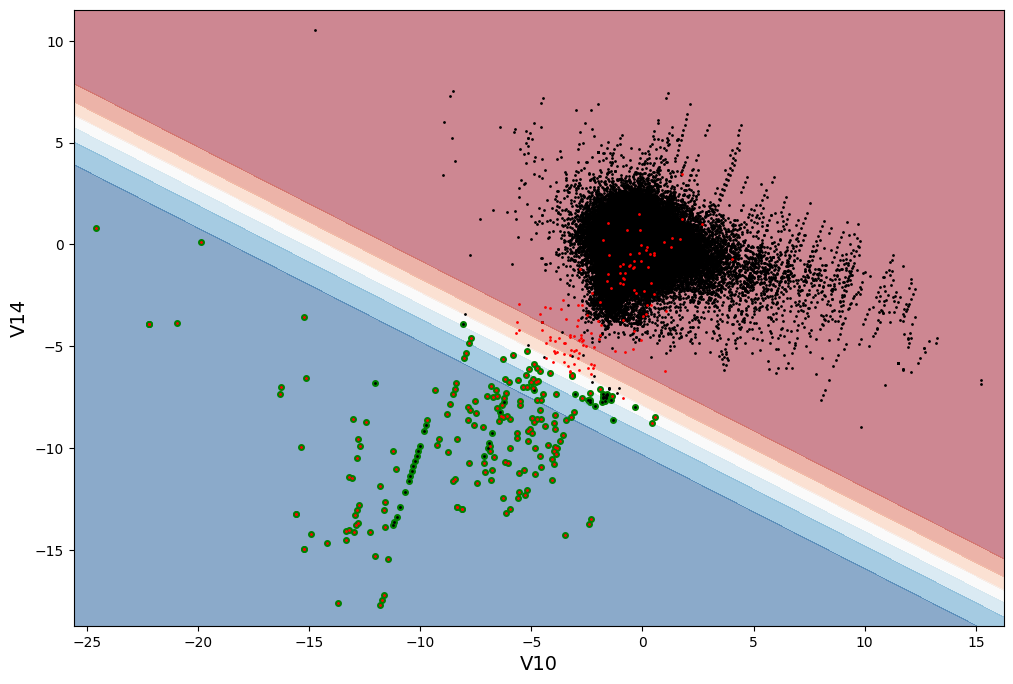

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(X_train_reduced[y_pred==1]["V10"], X_train_reduced[y_pred==1]["V14"], 'go', markersize=4)
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

**Predicción con el conjunto de datos reducido**

In [22]:
# Predicción con el conjunto de datos de prueba
y_pred = model.predict(X_test_reduced).round(0)

1781/1781 [==============================] - 1s 733us/step


In [23]:
from sklearn.metrics import f1_score

print("F1 Score:", f1_score(y_test, y_pred))

F1 Score: 0.7272727272727272
